In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as linalg
import torch_geometric.utils as utils
import torch_geometric.nn as gnn
from prettytable import PrettyTable
from sklearn.metrics import f1_score
from torch import Tensor
from torch.distributions import Bernoulli, MultivariateNormal
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import zeros
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, fill_diag, matmul, mul
from torch_sparse import sum as sparsesum
from torch_geometric.datasets import Planetoid
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.utils.num_nodes import maybe_num_nodes
from typing import Optional, Tuple
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
loss_fn = nn.CrossEntropyLoss()

Using device: cuda


## Helpers

In [2]:
# MLP with ReLU activations and sigmoidal output.
class MLP(torch.nn.Module):
    def __init__(self, n_layers, n_features, n_classes, channels=None):
        super().__init__()
        self.n_layers = n_layers
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Identity()
        self.dropout = nn.Dropout(0.5)
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = n_classes
            channels = [in_channels, out_channels]
        
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(nn.Sequential(
                nn.Linear(channels[0][i], channels[1][i]),
                self.activations[i]
            ))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x = data.x
        for (i, module) in enumerate(self.module_list):
            x = module(x)
            if i == 0:
                x = self.dropout(x)
        return x

def gcn_norm(edge_index, edge_weight=None, num_nodes=None, dtype=None):
    fill_value = 1.
    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
    
    edge_index, tmp_edge_weight = utils.add_remaining_self_loops(edge_index, edge_weight, fill_value, num_nodes)
    assert tmp_edge_weight is not None
    edge_weight = tmp_edge_weight

    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    deg_inv = deg.pow_(-1.)
    deg_inv.masked_fill_(deg_inv == float('inf'), 0)
    return edge_index, deg_inv[row] * edge_weight
    
# GCNConv module modified to consider multiple convolutions.
class GraphConv(MessagePassing):
    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int, bias: bool = True, num_convs: int = 1, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_convs = num_convs

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = nn.Linear(in_channels, out_channels, bias=False)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None) -> Tensor:
        edge_index, edge_weight = gcn_norm(  # yapf: disable
            edge_index, edge_weight, x.size(self.node_dim))
        x = self.lin(x)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = x
        for i in range(self.num_convs):
            out = self.propagate(edge_index, x=out, edge_weight=edge_weight, size=None)

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)
    
# MLP with ReLU activations and sigmoidal output.
class GCN(torch.nn.Module):
    def __init__(self, n_layers, n_features, n_classes, convolutions, channels=None):
        super().__init__()
        self.n_layers = n_layers
        self.convs = convolutions
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Identity()
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = n_classes
            channels = [in_channels, out_channels]
        
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(GraphConv(channels[0][i], channels[1][i], num_convs=self.convs[i]))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        for (i, module) in enumerate(self.module_list):
            x = module(x, edge_index)
            x = self.activations[i](x)
            if i < self.n_layers-1:
                x = F.dropout(x, training=self.training)
        return x

def train_model(model, data, loss_fn, lr=0.01, epochs=500, eps=1e-8, logs=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5.0e-4)
    model.train()
    epoch = 0
    print_freq = 20
    prev_loss = 0
    wspace = 8*' '
    while epoch < epochs:
        optimizer.zero_grad(set_to_none=True)
        out = model(data)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if logs is not None and epoch % print_freq == 0:
            print(logs + ' Loss: ' + str(round(loss.item(), 5)) + wspace, end='\r')
        if np.abs(prev_loss - loss.item()) <= eps and loss.item() < eps:
            break
        epoch += 1
        prev_loss = loss.item()

def train_one_epoch(model, optimizer, data, loss_fn, lr=0.01):
    optimizer.zero_grad(set_to_none=True)
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Compute prediction accuracy.
def accuracy(out, target):
    probs = torch.softmax(out, dim=1)
    winners = probs.argmax(dim=1)
    corrects = (winners == target)
    acc = corrects.sum().float() / target.size(0)
    return acc

def f1(out, target):
    probs = torch.softmax(out, dim=1)
    winners = probs.argmax(dim=1)
    return f1_score(target.data.cpu(), winners.data.cpu(), average='macro')

## Learners and Plot Helpers

In [3]:
datasets = [
    Planetoid(root='data/Cora/', name='Cora'),
    Planetoid(root='data/PubMed/', name='PubMed'),
    Planetoid(root='data/CiteSeer/', name='CiteSeer')]
model_types = [
    'MLP', # 2 layer MLPs
    '2L-10', # 2 layer GCN with 1 GC at layer 1
    '2L-01', # 2 layer GCN with 1 GC at layer 2
    '3L-100', # 3 layer GCN with 1 GC at layer 1
    '3L-010', # 3 layer GCN with 1 GC at layer 2
    '3L-001', # 3 layer GCN with 1 GC at layer 3
    '2L-20', # 2 layer GCN with 2 GCs at layer 1
    '2L-02', # 2 layer GCN with 2 GCs at layer 2
    '2L-11', # 2 layer GCN with 1 GC each at layers 1 and 2
    '3L-200', # 3 layer GCN with 2 GCs at layer 1
    '3L-020', # 3 layer GCN with 2 GCs at layer 2
    '3L-002', # 3 layer GCN with 2 GCs at layer 3
    '3L-110', # 3 layer GCN with 1 GC each at layers 1 and 2
    '3L-101', # 3 layer GCN with 1 GC each at layers 1 and 3
    '3L-011', # 3 layer GCN with 1 GC each at layers 2 and 3
]

# Initialize all learning models.
def init_learners(channels_2l, channels_3l, n_features, n_classes):
    learners = {}
    learners['MLP'] = MLP(n_layers=2, n_features=n_features, n_classes=n_classes, channels=channels_2l)
    learners['2L-10'] = GCN(n_layers=2, n_features=n_features, n_classes=n_classes, convolutions=[1, 0], channels=channels_2l)
    learners['2L-01'] = GCN(n_layers=2, n_features=n_features, n_classes=n_classes, convolutions=[0, 1], channels=channels_2l)
    learners['2L-20'] = GCN(n_layers=2, n_features=n_features, n_classes=n_classes, convolutions=[0, 2], channels=channels_2l)
    learners['2L-02'] = GCN(n_layers=2, n_features=n_features, n_classes=n_classes, convolutions=[2, 0], channels=channels_2l)
    learners['2L-11'] = GCN(n_layers=2, n_features=n_features, n_classes=n_classes, convolutions=[1, 1], channels=channels_2l)
    learners['3L-100'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[1, 0, 0], channels=channels_3l)
    learners['3L-010'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[0, 1, 0], channels=channels_3l)
    learners['3L-001'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[0, 0, 1], channels=channels_3l)
    learners['3L-200'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[2, 0, 0], channels=channels_3l)
    learners['3L-020'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[0, 2, 0], channels=channels_3l)
    learners['3L-002'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[0, 0, 2], channels=channels_3l)
    learners['3L-110'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[1, 1, 0], channels=channels_3l)
    learners['3L-101'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[1, 0, 1], channels=channels_3l)
    learners['3L-011'] = GCN(n_layers=3, n_features=n_features, n_classes=n_classes, convolutions=[0, 1, 1], channels=channels_3l)
    return learners

alph = .8
black = (.2, .2, .2, alph)
red = (.8, .1, .1, alph)
green = (.1, .8, .1, alph)
blue = (0., .3, .8, alph)
orange = (1., .6, .1, alph)
colors=[black, red, red, blue, blue, blue, green, green, green,
        orange, orange, orange, orange, orange, orange]

colors_std = []
for color in colors:
    color_std = (color[0], color[1], color[2], alph/3.)
    colors_std.append(color_std)

In [17]:
def plot_for_models(ds_name, x_axis, y_axis, y_err, y_label, filename=None):
    fig = plt.figure(figsize=(16,4), facecolor=[1,1,1])
    y_axis = 100*np.asarray(y_axis[ds_name])
    if y_err is None:
        y_err = np.zeros(len(x_axis))
    else:
        y_err = 100*np.asarray(y_err[ds_name])
    plt.ylim((0, 1.2*np.max(y_axis+y_err)))
    plt.bar(x_axis, y_axis, color=colors, width=0.5)
    plt.bar(x_axis, 2*y_err, color=colors_std, width=0.5, bottom=np.maximum(y_axis-y_err, np.zeros(y_axis.shape)))
    plt.xticks(x_axis, [s.upper() for s in model_types])
    txt_gap = .1*np.max(y_axis)
    for i, v in enumerate(y_axis):
        plt.text(i-.25, v + txt_gap, " "+str(round(v, 1)), color='black', va='center', fontweight='bold')
    plt.xlabel('Model', fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.show()
    if filename is not None:
        fig.savefig("figures/custom-gcnconv/" + filename, dpi=400, bbox_inches='tight')

def plot_all_metrics(ds_name):
#     fname = ds_name + '_train_acc.pdf'
#     plot_for_models(ds_name, x_coords, train_acc, train_acc_std, 'Training Accuracy', fname)
    fname = ds_name + '_test_acc_avg.pdf'
    plot_for_models(ds_name, x_coords, test_acc_avg, test_acc_std, 'Accuracy', fname)
    fname = ds_name + '_test_acc_max.pdf'
    plot_for_models(ds_name, x_coords, test_acc_max, None, 'Accuracy (max over trials)', fname)
    fname = ds_name + '_test_acc_epochmax_avg.pdf'
    plot_for_models(ds_name, x_coords, test_acc_epochmax_avg, test_acc_epochmax_std, 'Accuracy (max over epochs)', fname)
    fname = ds_name + '_test_acc_epochmax_max.pdf'
    plot_for_models(ds_name, x_coords, test_acc_epochmax_max, None, 'Accuracy (absolute max)', fname)
#     fname = ds_name + '_test_f1.pdf'
#     plot_for_models(ds_name, x_coords, test_f1, test_f1_std, 'Test F1 Score',  fname)
#     fname = ds_name + '_train_loss.pdf'
#     plot_for_models(ds_name, x_coords, train_loss, train_loss_std, 'Training Loss', fname)
#     fname = ds_name + '_test_loss.pdf'
#     plot_for_models(ds_name, x_coords, test_loss, test_loss_std, 'Test Loss', fname)

def print_all_metrics(ds):
    t = PrettyTable(['Model Name', 'Test Accuracy', 'Test Acc (max)', 'Test Acc EpochMax', 'Test Acc EpochMax (max)', 'Test Loss'])
    for m, mtype in enumerate(model_types):
        t.add_row([
            mtype,
            # str(round(100*train_acc[ds][m], 2)) + u' \u00B1 ' + str(round(100*train_acc_std[ds][m], 2)),
            str(round(100*test_acc_avg[ds][m], 2)) + u' \u00B1 ' + str(round(100*test_acc_std[ds][m], 2)),
            str(round(100*test_acc_max[ds][m], 2)),
            str(round(100*test_acc_epochmax_avg[ds][m], 2)) + u' \u00B1 ' + str(round(100*test_acc_epochmax_std[ds][m], 2)),
            str(round(100*test_acc_epochmax_max[ds][m], 2)),
            # str(round(train_loss[ds][m], 2)) + u' \u00B1 ' + str(round(train_loss_std[ds][m], 2)),
            str(round(test_loss[ds][m], 2)) + u' \u00B1 ' + str(round(test_loss_std[ds][m], 2))])
    print('METRICS FOR DATASET:', ds.upper())
    print(t)

## Train and test all models

In [ ]:
train_acc = {}
train_acc_std = {}
train_loss = {}
train_loss_std = {}
test_acc_avg = {}
test_acc_std = {}
test_acc_max = {}
test_acc_epochmax_avg = {}
test_acc_epochmax_std = {}
test_acc_epochmax_max = {}
test_f1 = {}
test_f1_std = {}
test_loss = {}
test_loss_std = {}

n_trials = 10
epochs = 200

# Define learning rates for various models, by number of layers.
lrs = {2: 0.01, 3: 0.01}

x_coords = np.arange(len(model_types))

for dataset in datasets:
    data = dataset[0].to(device)
    data.x_orig = copy.deepcopy(data.x)
    n_points, n_features = data.num_nodes, data.num_features
    n_classes = (data.y.max() + 1).data.cpu().numpy()
    print('\nWorking on ' + dataset.name + ': Classes =', n_classes.item(), '| Points =', n_points, '| Features =', n_features)
    train_acc[dataset.name] = [0]*len(model_types)
    train_acc_std[dataset.name] = [0]*len(model_types)
    train_loss[dataset.name] = [0]*len(model_types)
    train_loss_std[dataset.name] = [0]*len(model_types)
    test_acc_avg[dataset.name] = [0]*len(model_types)
    test_acc_std[dataset.name] = [0]*len(model_types)
    test_acc_max[dataset.name] = [0]*len(model_types)
    test_acc_epochmax_avg[dataset.name] = [0]*len(model_types)
    test_acc_epochmax_std[dataset.name] = [0]*len(model_types)
    test_acc_epochmax_max[dataset.name] = [0]*len(model_types)
#     test_f1[dataset.name] = [0]*len(model_types)
#     test_f1_std[dataset.name] = [0]*len(model_types)
    test_loss[dataset.name] = [0]*len(model_types)
    test_loss_std[dataset.name] = [0]*len(model_types)

    # Fix network architectures for the networks.
    channels_2l = [[n_features, 16], [16, n_classes]]
    channels_3l = [[n_features, 16, 16], [16, 16, n_classes]]

    train_acc_list = {}
    train_loss_list = {}
    test_acc_list = {}
    test_acc_epochmax_list = {}
    test_f1_list = {}
    test_loss_list = {}
    for model_type in model_types:
        train_acc_list[model_type] = torch.zeros(n_trials)
        train_loss_list[model_type] = torch.zeros(n_trials)
        test_acc_list[model_type] = torch.zeros(n_trials)
        test_acc_epochmax_list[model_type] = torch.zeros(n_trials)
        test_f1_list[model_type] = torch.zeros(n_trials)
        test_loss_list[model_type] = torch.zeros(n_trials)

    for t in range(n_trials):
        log_prefix = 'Progress: ' + str(round(100*t/n_trials, 2)) + '%.'
        learners = init_learners(channels_2l, channels_3l, n_features, n_classes)
        for model_type in model_types:
            logs = log_prefix + ' Model: ' + model_type + '.'
            learner = learners[model_type].to(device)
            
            # Train the learner.
            optimizer = torch.optim.Adam(learner.parameters(), lr=0.01, weight_decay=5.0e-4)
            learner.train()
            epoch = 0
            print_freq = 20
            prev_loss = 0
            wspace = 8*' '
            while epoch < epochs:
                loss_val = train_one_epoch(learner, optimizer, data, loss_fn, lr=0.01)
                if epoch % print_freq == 0:
                    print(logs + ' Loss: ' + str(round(loss_val, 5)) + wspace, end='\r')
                epoch += 1
                
                # Test acc at this epoch.
                learner.eval()
                out = learner(data)
                tacc = accuracy(out[data.test_mask], data.y[data.test_mask])
                test_acc_epochmax_list[model_type][t] = max(test_acc_epochmax_list[model_type][t], tacc)
                learner.train()
                
            
            # train_model(learner, data, loss_fn, lr=lrs[learner.n_layers], epochs=epochs, logs=logs)
            learner.eval()
            out = learner(data)
            train_acc_list[model_type][t] = accuracy(out[data.train_mask], data.y[data.train_mask])
            train_loss_list[model_type][t] = loss_fn(out[data.train_mask], data.y[data.train_mask])
            test_acc_list[model_type][t] = accuracy(out[data.test_mask], data.y[data.test_mask])
            test_f1_list[model_type][t] = f1(out[data.test_mask], data.y[data.test_mask])
            test_loss_list[model_type][t] = loss_fn(out[data.test_mask], data.y[data.test_mask])

    for (i, model_type) in enumerate(model_types):
        train_acc[dataset.name][i] = train_acc_list[model_type].mean().item()
        train_acc_std[dataset.name][i] = train_acc_list[model_type].std(unbiased=False).item()
        train_loss[dataset.name][i] = train_loss_list[model_type].mean().item()
        train_loss_std[dataset.name][i] = train_loss_list[model_type].std(unbiased=False).item()
        test_acc_avg[dataset.name][i] = test_acc_list[model_type].mean().item()
        test_acc_std[dataset.name][i] = test_acc_list[model_type].std(unbiased=False).item()
        test_acc_max[dataset.name][i] = test_acc_list[model_type].max().item()
        
        test_acc_epochmax_avg[dataset.name][i] = test_acc_epochmax_list[model_type].mean().item()
        test_acc_epochmax_std[dataset.name][i] = test_acc_epochmax_list[model_type].std(unbiased=False).item()
        test_acc_epochmax_max[dataset.name][i] = test_acc_epochmax_list[model_type].max().item()
        
#         test_f1[dataset.name][i] = test_f1_list[model_type].mean().item()
#         test_f1_std[dataset.name][i] = test_f1_list[model_type].std(unbiased=False).item()
        test_loss[dataset.name][i] = test_loss_list[model_type].mean().item()
        test_loss_std[dataset.name][i] = test_loss_list[model_type].std(unbiased=False).item()
    
    print('Progress: 100%.', 50*' ')
    print_all_metrics(dataset.name)
    plot_all_metrics(dataset.name)

## Plot and print metrics

METRICS FOR DATASET: CORA
+------------+---------------+----------------+-------------------+-------------------------+-------------+
| Model Name | Test Accuracy | Test Acc (max) | Test Acc EpochMax | Test Acc EpochMax (max) |  Test Loss  |
+------------+---------------+----------------+-------------------+-------------------------+-------------+
|    MLP     |  51.7 ± 2.01  |      55.3      |    53.02 ± 1.53   |           55.7          | 1.67 ± 0.09 |
|   2L-10    |  72.93 ± 1.72 |      75.3      |    74.7 ± 1.12    |           76.9          | 0.91 ± 0.07 |
|   2L-01    |  75.43 ± 1.12 |      77.2      |    76.7 ± 1.02    |           77.6          | 0.81 ± 0.02 |
|   3L-100   |  67.44 ± 3.9  |      73.3      |    71.62 ± 2.53   |           75.5          |  1.35 ± 0.2 |
|   3L-010   |  73.27 ± 1.94 |      76.5      |    74.6 ± 2.11    |           77.2          | 1.05 ± 0.09 |
|   3L-001   |  72.32 ± 1.63 |      74.9      |    74.38 ± 2.09   |           77.2          | 1.13 ± 0.11 |
| 

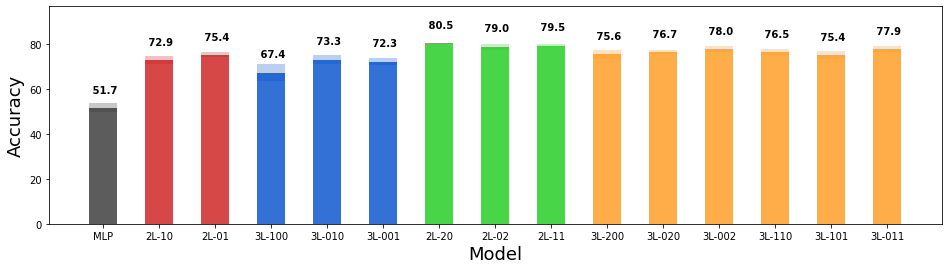

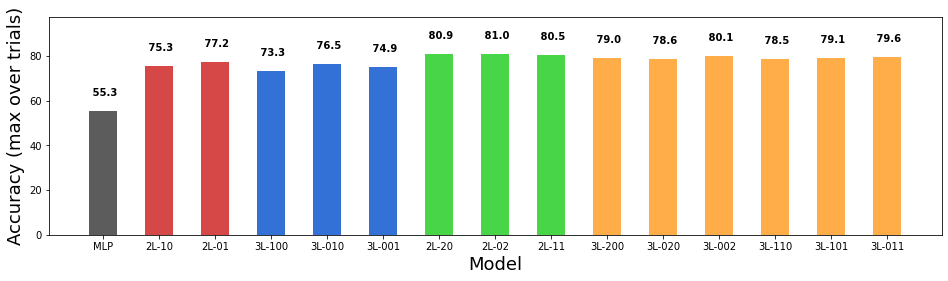

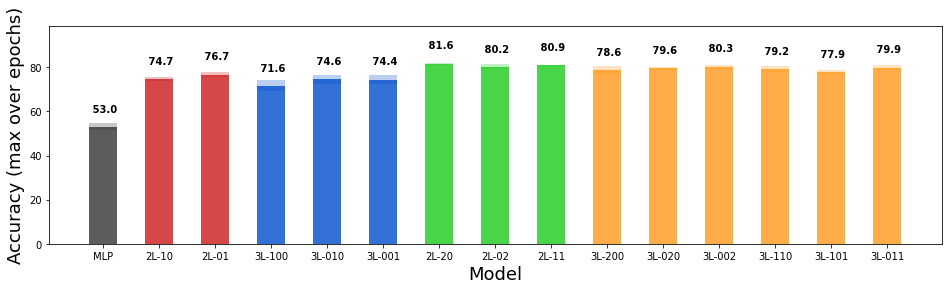

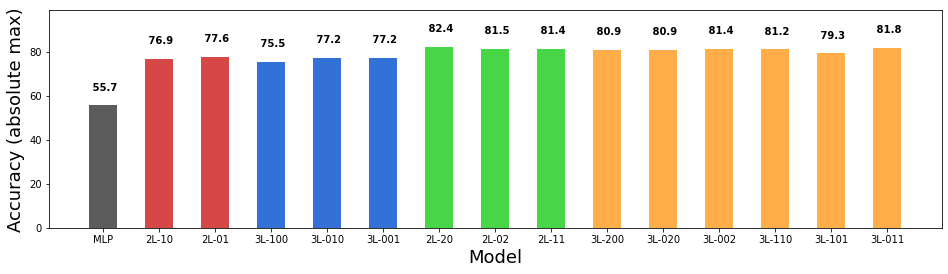

METRICS FOR DATASET: PUBMED
+------------+---------------+----------------+-------------------+-------------------------+-------------+
| Model Name | Test Accuracy | Test Acc (max) | Test Acc EpochMax | Test Acc EpochMax (max) |  Test Loss  |
+------------+---------------+----------------+-------------------+-------------------------+-------------+
|    MLP     |  71.67 ± 2.1  |      73.8      |    72.66 ± 1.21   |           73.9          | 0.75 ± 0.04 |
|   2L-10    |  72.46 ± 1.0  |      73.9      |    74.04 ± 0.53   |           74.6          | 0.74 ± 0.02 |
|   2L-01    |  72.37 ± 0.88 |      73.9      |    74.15 ± 0.81   |           75.0          | 0.76 ± 0.02 |
|   3L-100   |  68.5 ± 3.62  |      72.3      |    72.69 ± 1.69   |           74.6          | 1.11 ± 0.17 |
|   3L-010   |  72.71 ± 1.31 |      74.6      |    74.12 ± 0.75   |           75.3          | 1.08 ± 0.09 |
|   3L-001   |  72.17 ± 1.61 |      74.0      |    74.48 ± 0.52   |           75.2          | 1.21 ± 0.13 |


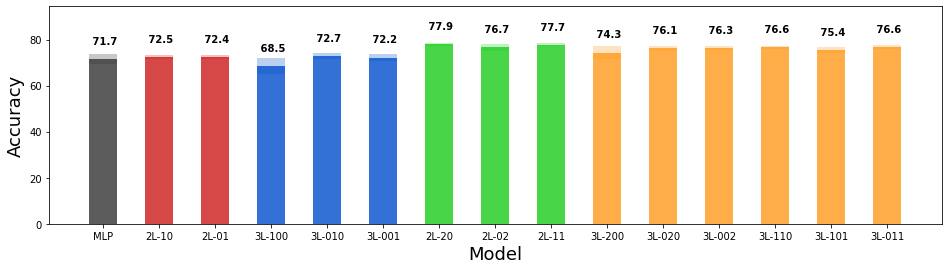

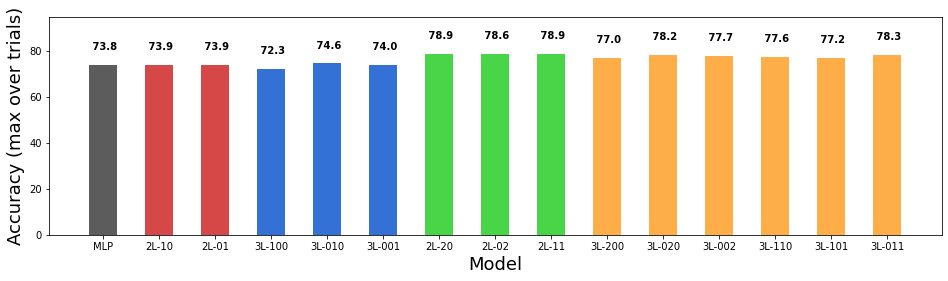

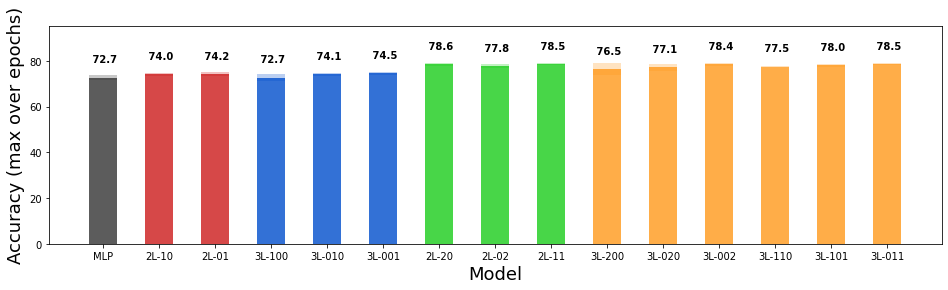

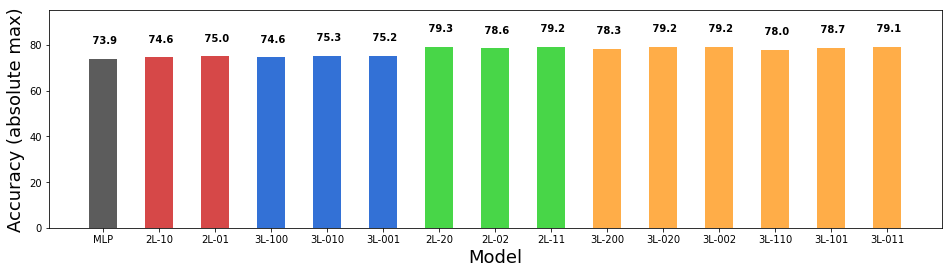

METRICS FOR DATASET: CITESEER
+------------+---------------+----------------+-------------------+-------------------------+-------------+
| Model Name | Test Accuracy | Test Acc (max) | Test Acc EpochMax | Test Acc EpochMax (max) |  Test Loss  |
+------------+---------------+----------------+-------------------+-------------------------+-------------+
|    MLP     |  51.98 ± 2.58 |      55.6      |    52.97 ± 2.46   |           56.2          | 1.56 ± 0.16 |
|   2L-10    |  66.26 ± 1.34 |      68.3      |    67.61 ± 1.36   |           69.4          |  1.2 ± 0.06 |
|   2L-01    |  65.95 ± 1.38 |      68.2      |    67.69 ± 1.17   |           69.1          | 1.13 ± 0.04 |
|   3L-100   |  61.76 ± 2.22 |      64.9      |    64.25 ± 1.63   |           66.7          | 1.62 ± 0.08 |
|   3L-010   |  64.58 ± 1.69 |      68.3      |    66.45 ± 1.19   |           68.4          | 1.53 ± 0.09 |
|   3L-001   |  62.14 ± 2.41 |      66.0      |    64.79 ± 1.13   |           66.4          | 1.74 ± 0.17 

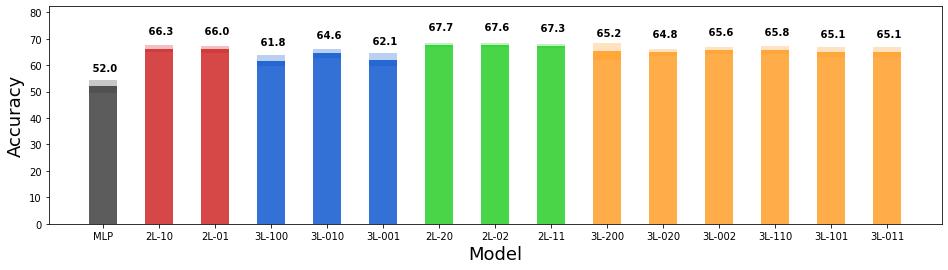

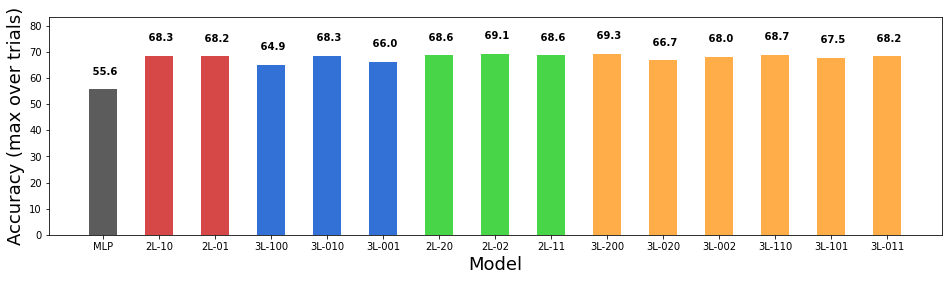

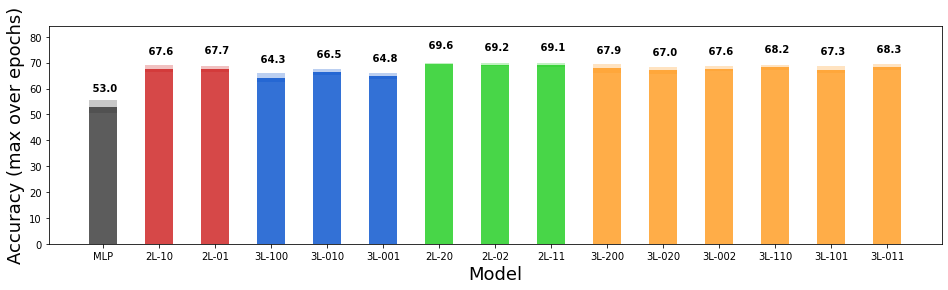

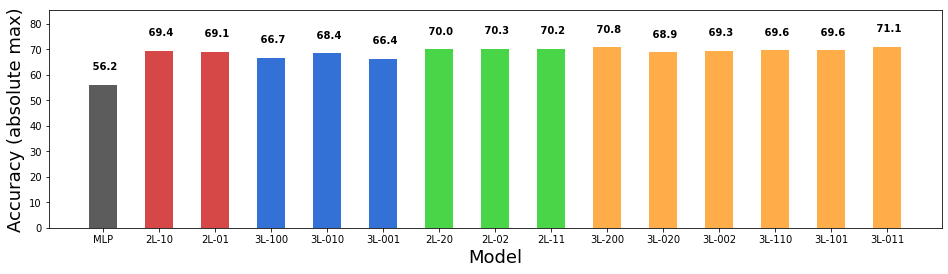

In [20]:
for dataset in datasets:
    print_all_metrics(dataset.name)
    plot_all_metrics(dataset.name)